In [58]:
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import glob

from IPython.display import display, JSON, clear_output

In [59]:
from EventReader import EventReader
from EventReader import show_data
import pandas as pd

#### Check all available data

In [60]:
data_dir = '/data/xenon/acolijn/optosim/data/'
show_data(data_dir)

,subdir,detector,nevents,nphoton_per_event,set_no_scatter,set_experimental_scatter_model,radius
0,mc0000,XAMS,1000,100000,False,True,3.2
1,mc0001,XAMS,10000,10000,False,True,3.2
2,mc0002,XAMS,10000,10000,True,True,3.2
3,mc0003,XAMS,10000,10000,False,False,3.2
4,mc0004,XAMS,10000,10000,False,True,3.2
5,mc0005,XAMS,10000,10000,True,True,3.2
6,mc9999,XAMS,100,10000,False,True,8.0


#### Get all the file names and initialize the data reader class

In [65]:
files = glob.glob('/data/xenon/acolijn/optosim/data/mc0001/*0000.hd5f')

#### Loop over the events

In [66]:
%%time
events = EventReader(files)
plot = False

n = 0
nmax =10000 # if you do not want to loop over all events

xp = []
yp = []
q_tb = []
q_lr = []
q_tot = []

data_dict = { 
    'x': [],
    'y': [],
    'q_b': [],
    'q_l': [],
    'q_tot': []
}


for ev in events:
    if n%1000 == 0:
        print('processed ',n,'events')#, events.print_event(ev))
    n+=1
    
    if plot:
        events.show_event(ev)
        response = input("Press Enter to continue to the next event or 'q' to quit...")

        if response.lower() == 'q':
            print("Quit the event display......")
            break
        
        clear_output(wait=True)
    
    # retrieve the true hit position
    x_true = ev['true_position'][()]
    data_dict['x'].append(x_true[0])
    data_dict['y'].append(x_true[1])
    
    # get the data from the top PMT    
    pmt = ev['pmt_top'][()]
    qtot = float(np.sum(pmt))
    data_dict['q_b'].append((pmt[0][0] + pmt[1][0]))
    data_dict['q_l'].append((pmt[0][0] + pmt[0][1]))
    data_dict['q_tot'].append(qtot)
    
    if n>nmax:
        break
            
df = pd.DataFrame(data_dict)
df['r'] = np.sqrt(df['x']**2+df['y']**2)
df['q_tb'] = df['q_b']/df['q_tot']
df['q_lr'] = df['q_l']/df['q_tot']


events.reset()

number of files:  1
processed  0 events
processed  1000 events
processed  2000 events
processed  3000 events
processed  4000 events
processed  5000 events
processed  6000 events
processed  7000 events
processed  8000 events
processed  9000 events
CPU times: user 13.2 s, sys: 496 ms, total: 13.7 s
Wall time: 24.6 s


#### Plot the charge ratio

Two plots: (i) $Q_L / Q_{tot}$ as a function of $x$ (ii) $Q_B / Q_{tot}$ as a function of $y$.

Text(0, 0.5, '$Q_B / Q_{tot}$')

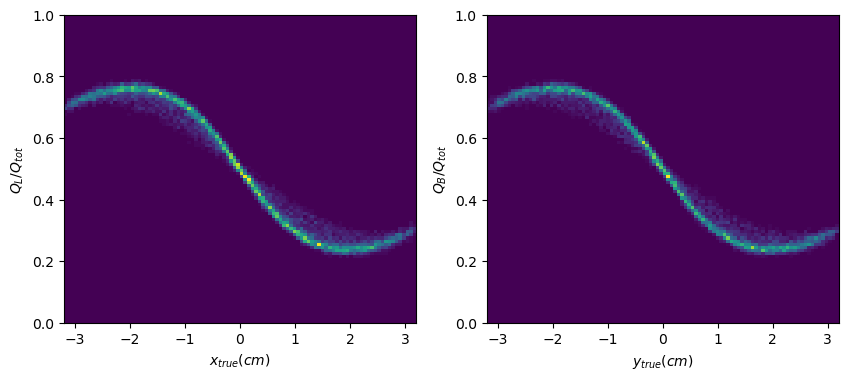

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

R = events.config['geometry']['radius']

h1 = axs[0].hist2d(df['x'],df['q_lr'],bins=(100,100), range=((-R,R),(0,1)))
axs[0].set_xlabel('$x_{true} (cm)$')
axs[0].set_ylabel('$Q_L / Q_{tot}$')

h2 = axs[1].hist2d(df['y'],df['q_tb'],bins=(100,100), range=((-R,R),(0,1)))
axs[1].set_xlabel('$y_{true} (cm)$')
axs[1].set_ylabel('$Q_B / Q_{tot}$')

Text(0, 0.5, '$Q_B$')

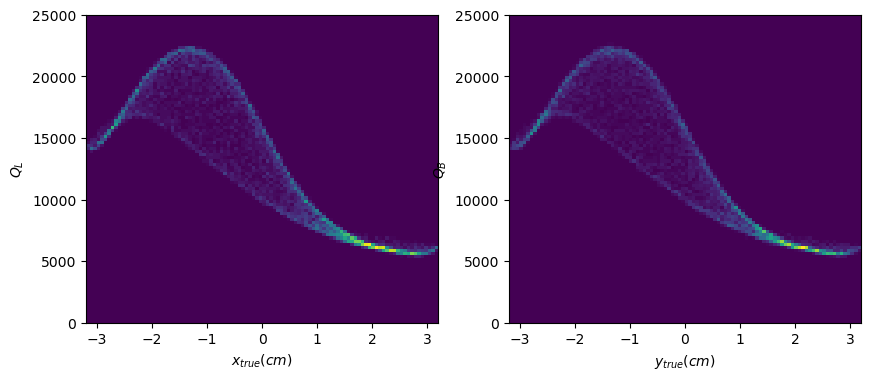

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

R = events.config['geometry']['radius']

h1 = axs[0].hist2d(df['x'],df['q_l'],bins=(100,100), range=((-R,R),(0,25000)))
axs[0].set_xlabel('$x_{true} (cm)$')
axs[0].set_ylabel('$Q_L$')

h2 = axs[1].hist2d(df['y'],df['q_b'],bins=(100,100), range=((-R,R),(0,25000)))
axs[1].set_xlabel('$y_{true} (cm)$')
axs[1].set_ylabel('$Q_B$')

.... and also $Q_{tot}$ as a function of radius.

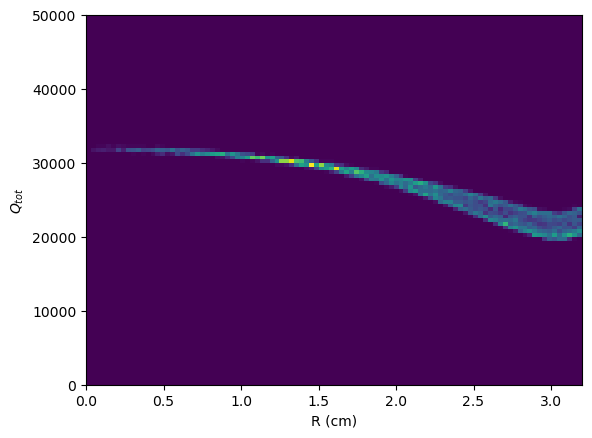

In [22]:
xp = np.array(xp)
yp = np.array(yp)
R = events.config['geometry']['radius']

r2 = np.sqrt(df['x']**2+df['y']**2)
h=plt.hist2d(r2,df['q_tot'],bins=100, range=((0,R),(0,50000)))
plt.xlabel('R (cm)')
plt.ylabel('$Q_{tot}$')
plt.show()

#### Event display

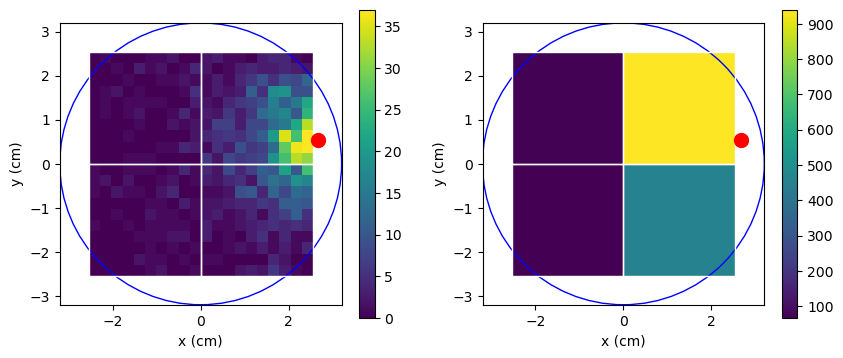

[2.66873937 0.53493154 0.1       ]
Press Enter to continue to the next event or 'q' to quit...Q
Quit the event display......


In [57]:
events = EventReader(files)

for ev in events:
    events.show_event(ev)

    print(ev['true_position'])
    response = input("Press Enter to continue to the next event or 'q' to quit...")

    if response.lower() == 'q':
        print("Quit the event display......")
        break
        
    clear_output(wait=True)

events.reset()

#### Little hack to add attributes to the hd5f files..... be careful!


In [9]:
filename='/data/xenon/acolijn/optosim/data/mc0005/mc0005.0000.hd5f'

filename='xxxxxx' # just for safety
with h5py.File(filename, 'r+') as f:
    config_str = f.attrs['config']
    config_dict = json.loads(config_str)  # Parse the string to get a dictionary
    config_dict['detector'] = 'XAMS'
    modified_config_str = json.dumps(config_dict)  # Convert the modified dictionary back to a string
    f.attrs['config'] = modified_config_str


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'xxxxxx', errno = 2, error message = 'No such file or directory', flags = 1, o_flags = 2)

In [10]:
events.close()